# 以太坊区块链性能优化 EthOptimize 

环境的基本信息如下表所示，所需库如下所示

| Info | Detail |
|----------|----------|
| action space    | Discrete(5)      |
| Observation shape    | (2, )     |
| Observation High    | [300000, 25]     |
| Observation Low    | [150000, 5]     |
| Import    | gym.make("EthOptimize")     |

In [1]:
import gym
from gym import spaces
import numpy as np

## Description

现有对以太坊区块链不同负载环境下的性能数据进行测试，且具有不同的交易吞吐量（TPS），为了获得较高的交易吞吐量，需要学习如何调整已有的控制参数：区块大小以及出块间隔，来获得更高的tps。在场景测试时，选取的区块大小和出块间隔参数是离散的。
定义一个以太坊优化类class EthOptimize作为强化学习的自定义环境，类需要包括如下函数。

In [2]:
class EthOptimize(gym.Env):
    def __init__(self):
        self.upper_bsize = 300000
        self.lower_bsize = 150000
        self.upper_btime = 25
        self.lower_btime = 5
        self.action_space = spaces.Discrete(5) # 0, 1, 2, 3, 4
        self.observation_space = spaces.Box(np.array([self.lower_bsize, self.upper_bsize]), np.array([self.lower_btime, self.upper_btime]))
        self.state = None
        self.counts = 0

    # 下一步执行函数，从agent收到下一步的action后执行该action，返回state, reward, done, {info}
    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        x, y = self.state
        if action == 0:
            x=x
            y=y
        elif action == 1:
            x = x + 1500
            y = y
        elif action == 2:
            x = x - 1500
            y = y
        elif action == 3:
            x = x
            y = y + 1
        elif action == 4:
            x = x
            y = y - 1
        self.state = np.array([x, y])
        self.counts += 1

        done = None # justify border 
        done = bool(done)

        reward = None
        '''
        if not done:
            reward -= 0.1
        else:
            if ...
        '''
        
        return self.state, reward, done, {}

    # 重置函数，每一个episode都要重置环境进行下一个轮次的训练
    def reset(self):
        # state初始化，回到一个初始状态，为下一个周期准备
        self.state = np.array([151500, 7])
        return self.state 


In [ ]:
def __init__(self):
    self.upper_bsize = 30000000 # 区块大小上限
    self.lower_bsize = 15000000 # 区块大小下限
    self.upper_btime = 25 # 出块间隔上限
    self.lower_btime = 5 # 出块间隔下限
    self.action_space = spaces.Discrete(5) # 0, 1, 2, 3, 4，分别代表的含义在step中定义
    self.observation_space = spaces.Box(np.array([self.lower_bsize, self.upper_bsize]), np.array([self.lower_btime, self.upper_btime]))
    self.state = None
    self.counts = 0

## Action Space

有五个离散的操作：增加区块大小，减小区块大小、增加出块间隔，减小出块间隔，DoNothing。

In [ ]:
assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
x, y = self.state # x是区块大小，y是出块时间
if action == 0:
    x=x
    y=y
elif action == 1:
    x = x + 150000
    y = y
elif action == 2:
    x = x - 150000
    y = y
elif action == 3:
    x = x
    y = y + 1
elif action == 4:
    x = x
    y = y - 1
self.state = np.array([x, y])
self.counts += 1

## Observation Space

状态是一个二维向量：区块大小（blocksize），出块间隔（blocktime）

## Rewards

根据文献 Li M, Wang Y, Ma S, et al. Auto-tuning with reinforcement learning for permissioned blockchain systems[J]. Proceedings of the VLDB Endowment, 2023, 16(5): 1000-1012. 的奖励函数设计。  

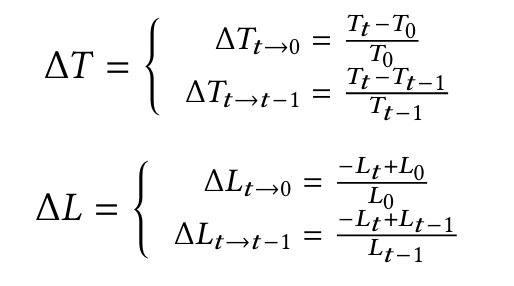  

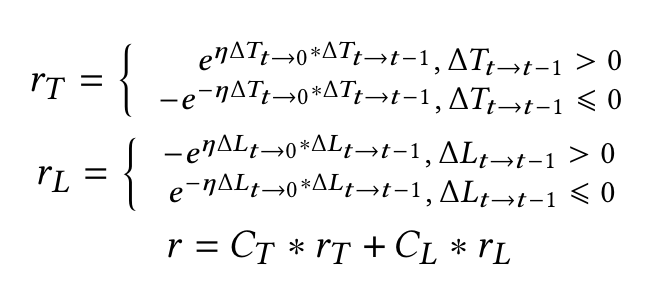  

对于参数的选择，由于我们的测试性能指标变化不明显，所以，将扩展性能因子缩小到0.5,并且使用tps作为主要的评价指标，并使用延迟作为一定的约束，所以给tps的影响因子为0.7，延迟为0.3

In [32]:

import math
import numpy as np

def getReward(state_, state, state0):
    # get delta value
    gamma = 0.5
    T_0, L_0 = state0
    T_t, L_t = state_
    T_t_1, L_t_1 = state
    delta_T_orig = (T_t - T_0) / T_0
    delta_T_step = (T_t - T_t_1) / T_t_1
    delta_L_orig = (- L_t + L_0) / L_0
    delta_L_step = (- L_t + L_t_1) / L_t_1

    # print("delta_T_orig = ", delta_T_orig)
    # print("delta_T_step = ", delta_T_step)
    # print("delta_L_orig = ", delta_L_orig)
    # print("delta_L_step = ", delta_L_step)
    
    # compute reward value rT and rL
    if delta_T_step > 0:
        rT = math.exp(gamma * delta_T_orig * delta_T_step)
    elif delta_T_step <= 0:
        rT = - math.exp(- gamma * delta_T_orig * delta_T_step)
    
    if delta_L_step > 0:
        rL = - math.exp(gamma * delta_L_orig * delta_L_step)
    elif delta_L_step <= 0:
        rL = math.exp(- gamma * delta_L_orig * delta_L_step)
    
    reward = 0.7 * rT + 0.3 * rL
    return reward, {'rT = ', rT, 'rL = ', rL}

if __name__ == "__main__":
    state0 = np.array([5, 10])
    state = np.array([5, 10])
    state_ = np.array([5, 9])
    reward, info = getReward(state_, state, state0)
    print(reward, info)

-1.0015037562578202 {'rT = ', 'rL = ', -1.0, -1.005012520859401}


可以看到，当tps相比初始状态有提升，但是比前一状态下降，一样会减少reward  
继续尝试验证，假设初始与前一状态不变，当tps比前一状态小，延迟比初始低但是比上一状态高，即[6, 8]，求reward变化

In [34]:
state_ = np.array([5, 100])
reward = getReward(state_, state, state0)
print(reward)

(-0.7, {'rT = ', 'rL = ', 2.576757109154981e-18, -1.0})


由于比上一个例子性能更差了，所以reward减少的也更多。  
当为[8, 5],[8, 6],[8, 7]时，reward变化为

In [25]:
state_list = [np.array([8, 1]), np.array([8, 6]), np.array([8, 20])]
for item in state_list:
    state_ = item
    reward = getReward(state_, state, state0)
    print("当前性能： ", state_, "奖励变化：", reward) 

当前性能：  [8 1] 奖励变化： (0.2941547156768276, {0.9, 0.8333333333333334})
当前性能：  [8 6] 奖励变化： (1.030652140062288, {0.4, 0.0})
当前性能：  [ 8 20] 奖励变化： (0.8240731072366673, {-2.3333333333333335, -1.0})


## Starting State

在对应控制参数的区间内取随机的一个状态作为开始状态，这个状态在reset函数中声明

In [ ]:
def reset(self):
    # state初始化，回到一个初始状态，为下一个周期准备
    self.state = np.array([151500, 7])
    return self.state 

## Episode End

讨论当什么时候episode结束，初步给出如下限制：
1. 当区块大小超过上下界时
2. 当区块间隔超过上下界时
3. episode的上限（即当episode达到多少时不再训练  

在step中给出是否结束该次训练的结果，用done（一个bool值）表示

In [ ]:
done = None # need to justify border here
done = bool(done)

In [3]:
import numpy as np
testx = 1
testy = 2
p1 = np.array([testx, testy])
p2 = np.array([testx, testy])
done = np.array_equal(p1, p2)
print(done)


True


具体参考案例如下：
1. [自定义一个强化学习环境](https://zhuanlan.zhihu.com/p/33553076)
2. [OpenAI Gym库文档经典案例](https://www.gymlibrary.dev/environments/classic_control/)

### 补充： 环境与gym库的构建

当构建完一个简单的模拟器后，通过使用openai的stable-baseline3的check_env来检查构建的模拟器是否存在问题，从而在训练时加载编译环境不会出错

In [ ]:
if __name__ == "__main__":
    from stable_baselines3.common.env_checker import check_env 
    import eth_optimize as src
    # 如果你安装了pytorch，则使用上面的，如果你安装了tensorflow，则使用from stable_baselines.common.env_checker import check_env
    env = src.EthOptimize()
    check_env(env)

这里使用一个简单的sim实例跑一遍，总结出以下的一些问题，实例文件为“/Users/apple/Documents/GitHub/Double-DQN/Mysim.py”

Q1: 版本匹配问题

stable_baselines3后续使用了优化的gym库，即gymnasium，所以在定义时搞清楚引用的版本是什么

```
    check_env(env)
  File "/Users/apple/opt/anaconda3/envs/ddqn-env/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py", line 409, in check_env
    assert isinstance(
AssertionError: Your environment must inherit from the gymnasium.Env class cf. https://gymnasium.farama.org/api/env/
```

Q2: 状态空间的生成

引入high和low来避免识别问题

```
Traceback (most recent call last):
  File "/Users/apple/Documents/GitHub/Double-DQN/eth_optimize.py", line 68, in <module>
    env = EthOptimize()
  File "/Users/apple/Documents/GitHub/Double-DQN/eth_optimize.py", line 13, in __init__
    self.observation_space = spaces.Box(np.array([self.lower_bsize, self.upper_bsize]), np.array([self.lower_btime, self.upper_btime]))
  File "/Users/apple/opt/anaconda3/envs/ddqn-env/lib/python3.9/site-packages/gymnasium/spaces/box.py", line 126, in __init__
    raise ValueError(
ValueError: Some low values are greater than high, low=[150000. 300000.], high=[ 5. 25.]
```

Q3: reset函数

新版本的reset函数需接受一个seed作为输入，并且在输出时需要加一个info组成元组输出
```
Traceback (most recent call last):
  File "/Users/apple/opt/anaconda3/envs/ddqn-env/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py", line 421, in check_env
    env.reset(seed=0)
TypeError: reset() got an unexpected keyword argument 'seed'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/apple/Documents/GitHub/Double-DQN/eth_optimize.py", line 71, in <module>
    check_env(env)
  File "/Users/apple/opt/anaconda3/envs/ddqn-env/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py", line 423, in check_env
    raise TypeError("The reset() method must accept a `seed` parameter") from e
TypeError: The reset() method must accept a `seed` parameter

Traceback (most recent call last):
  File "/Users/apple/Documents/GitHub/Double-DQN/eth_optimize.py", line 68, in <module>
    check_env(env)
  File "/Users/apple/opt/anaconda3/envs/ddqn-env/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py", line 461, in check_env
    _check_returned_values(env, observation_space, action_space)
  File "/Users/apple/opt/anaconda3/envs/ddqn-env/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py", line 264, in _check_returned_values
    assert isinstance(reset_returns, tuple), "`reset()` must return a tuple (obs, info)"
AssertionError: `reset()` must return a tuple (obs, info)
```


Q4: step函数需输出声明是否截断truncate

```
Traceback (most recent call last):
  File "/Users/apple/Documents/GitHub/Double-DQN/Mysim.py", line 35, in <module>
    check_env(env)
  File "/Users/apple/opt/anaconda3/envs/ddqn-env/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py", line 461, in check_env
    _check_returned_values(env, observation_space, action_space)
  File "/Users/apple/opt/anaconda3/envs/ddqn-env/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py", line 294, in _check_returned_values
    assert len(data) == 5, (
AssertionError: The `step()` method must return five values: obs, reward, terminated, truncated, info. Actual: 4 values returned.
```

最后验证没有其他错误，可以与gym库互联编译

```
(ddqn-env)  apple@appledeMacBook-Pro-2 ~/Documents/GitHub/Double-DQN > python Mysim.py
(ddqn-env)  apple@appledeMacBook-Pro-2 ~/Documents/GitHub/Double-DQN > 
```

In [6]:
from clean_data import Final_Dataframe
df = Final_Dataframe()

usage: ipykernel_launcher.py [-h] [--dfpt DFPT]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/nlsde/.local/share/jupyter/runtime/kernel-v2-23116jAcUUxZzgv9Y.json


SystemExit: 2

/home/nlsde/anaconda3/envs/ddqn/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
